In [1]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING'

In [2]:
import scipy.io as sio
from scipy import signal
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d
from scipy.signal import correlate2d
from scipy.signal import fftconvolve
from scipy.signal import convolve
from scipy.signal import correlate
from devito import Function, TimeFunction, norm

# Contoh membaca file .mat
data = sio.loadmat("BG450_model.mat")
print(data.keys())
# Misalkan velocity model ada di key tertentu, misalnya 'velocity_model':
vp = data['v'].T[100:300]
#vp0 = np.loadtxt('Vp0 model Padded.txt')
#vp0 = (vp0.T)/1000
vp0 = gaussian_filter(vp, 10) #velocity model intial

print(np.min(vp0))
print(np.max(vp0))

vp0.shape

dict_keys(['__header__', '__version__', '__globals__', 'v', 'n', 'd', 'o'])
1.4912071034812064
4.304304063189347


(200, 205)

In [3]:
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu May 22 10:15:50 2014',
 '__version__': '1.0',
 '__globals__': [],
 'v': array([[1.46356058, 1.46638119, 1.48230541, ..., 1.49039567, 1.46701777,
         1.45383   ],
        [1.46647811, 1.47416615, 1.48770535, ..., 1.49200451, 1.47077906,
         1.45204437],
        [1.45675921, 1.47178292, 1.48595953, ..., 1.49092162, 1.46984661,
         1.44722259],
        ...,
        [4.09731007, 4.09630251, 4.09983778, ..., 3.99882603, 3.98956394,
         3.98412228],
        [4.13336897, 4.13244724, 4.13520861, ..., 4.06025696, 4.04679441,
         4.03740788],
        [4.15405846, 4.15371513, 4.15621567, ..., 4.11098623, 4.09505844,
         4.0832634 ]]),
 'n': array([[205, 451]], dtype=uint16),
 'd': array([[10, 10]], dtype=uint8),
 'o': array([[0, 0]], dtype=uint8)}

In [4]:
nshots = 11  # Number of shots to create gradient from
nreceivers = 120  # Number of receiver locations per shot 
fwi_iterations = 5  # Number of outer FWI iterations

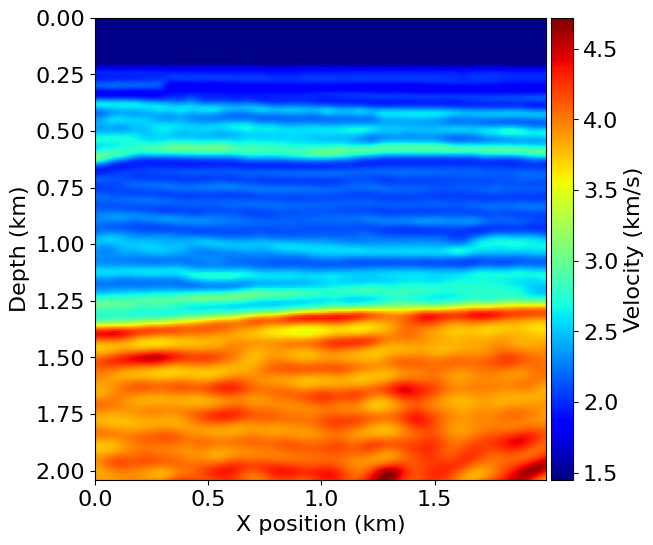

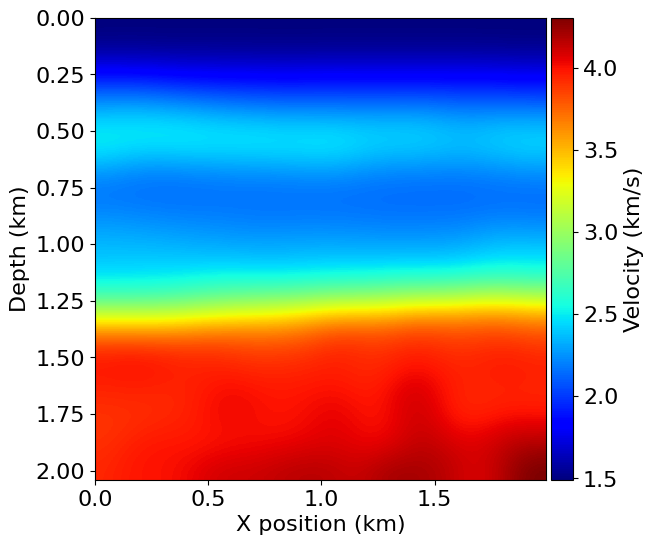

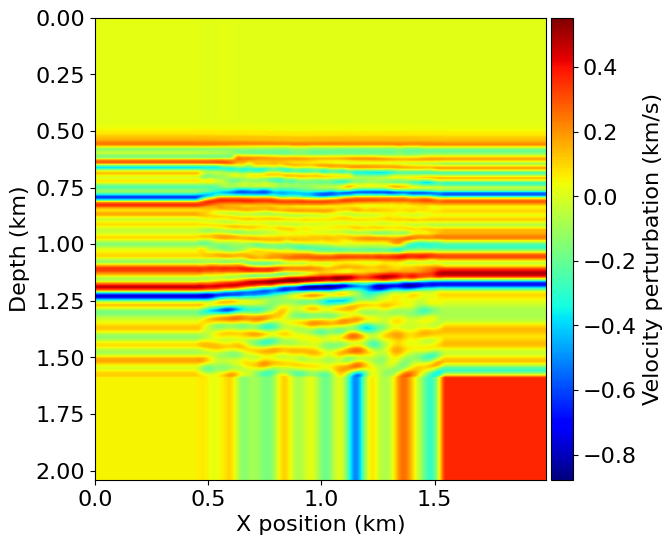

In [5]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, plot_velocity, plot_perturbation, Receiver

# Define a physical size
shape = (vp0.shape)  # Number of grid point (nx, nz)
spacing = (10, 10)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0.,0.)  # What is the location of the top left corner. This is necessary to define
nboundary = 80

model = Model(vp=vp, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp")

model0 = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)

plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

In [6]:
waterheight = 24
watermute = Function(name="watermute", grid=model.grid)
watermute.data[:,nboundary+waterheight:] += 1

In [7]:
#NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: source
from examples.seismic import AcquisitionGeometry, TimeAxis, RickerSource, PointSource, WaveletSource

t0 = 0.
tn = 1600. 
dt = model.critical_dt
time = TimeAxis(start=t0, stop=tn, step=dt)


f0 = 0.010

# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((nshots, 2))
src_coordinates[:, 0] = np.linspace(605, 1405, nshots)
src_coordinates[:, 1] = 20.  # Depth is 20m

In [8]:
geometrys = []

for i in range(nshots):
    # Define acquisition geometry: receivers

    # Initialize receivers for synthetic and imaging data
    rec_coordinates = np.empty((nreceivers, 2))
    rec_coordinates[:, 0] = np.linspace(10+(i*80), 1200+(i*80), nreceivers)
    rec_coordinates[:, 1] = 20.  # Depth is 20m

    # Geometry
    geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
    geometrys.append(geometry)
print(geometrys[0].time_axis)

TimeAxis: start=0, stop=1600.5, step=1.297, num=1235


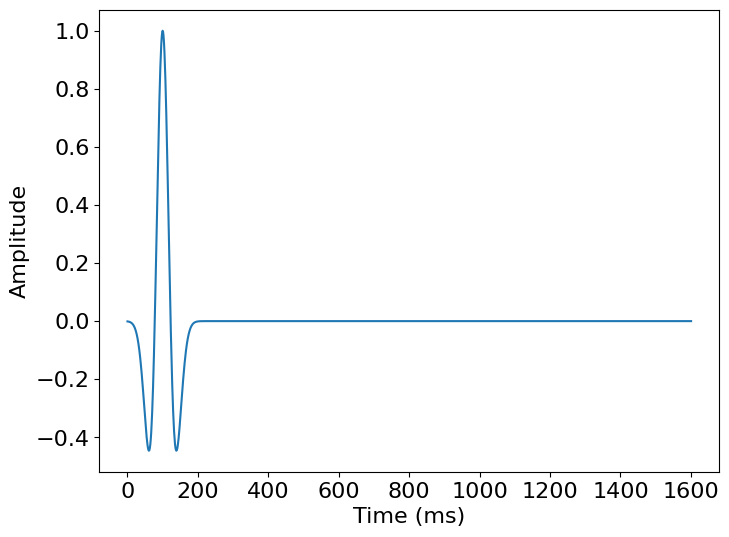

(1235, 1)

In [9]:
srct = []

for i in range(nshots):
    src = RickerSource(name='src', grid=model0.grid, f0=f0, time_range=time)
    # First, position source centrally in all dimensions, then set depth
    src.coordinates.data[0, :] = src_coordinates[i, 0]
    src.coordinates.data[0, -1] = 20.  # Depth is 20m
    #src.data[:] *= -1
    srct.append(src)
srct[0].show()
srct[0].data.shape

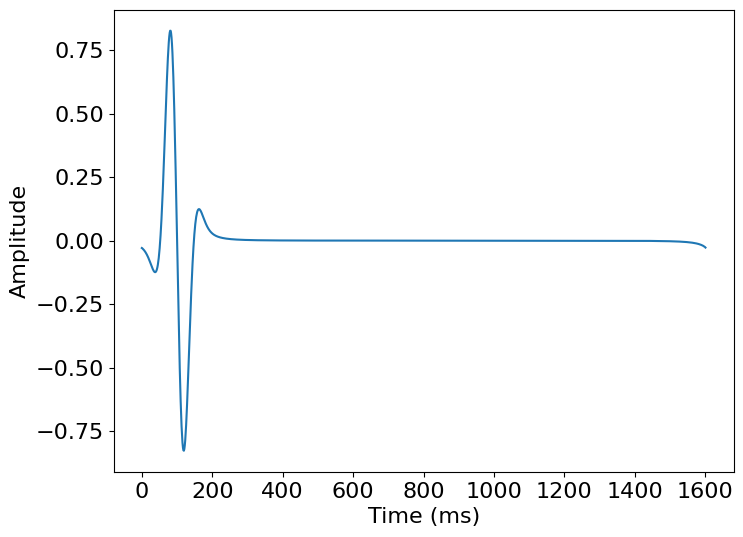

(1235, 1)

In [10]:
t = np.arange(t0, tn+dt, (dt))
t = t/1000
f0z = f0*1000
t0 = (1/f0z)
st = (1 - (2*(np.pi**2)*(f0z**2)*(t-t0)**2))*(np.exp(-1*(np.pi**2)*(f0z**2)*(t-t0)**2))

wavelet = st

angle = 90
shifted = np.real(np.exp(1j*np.radians(angle)) * signal.hilbert(wavelet))
shifted = np.array([shifted])
shiftedT = shifted.T

srcs = []

for i in range(nshots):
    src = RickerSource(name='src', grid=model0.grid, f0=f0, time_range=time)
    # First, position source centrally in all dimensions, then set depth
    src.coordinates.data[0, :] = src_coordinates[i, 0]
    src.coordinates.data[0, -1] = 20.  # Depth is 20m
    src.data[:] = shiftedT
    srcs.append(src)
srcs[0].show()
srcs[0].data.shape

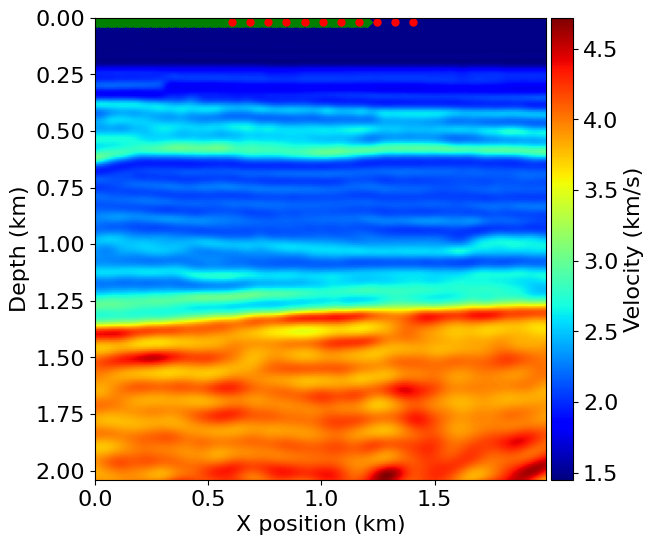

In [11]:
#NBVAL_IGNORE_OUTPUT
# Plot acquisition geometry
plot_velocity(model, source=geometrys[0].src_positions,
              receiver=geometrys[0].rec_positions)

In [12]:
# Compute synthetic data with forward operator 
from examples.seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, geometry, space_order=2)

print(solver)

In [13]:
from devito import Eq, Operator

# Computes the residual between observed and synthetic data into the residual
def compute_residual(residual, dobs, dsyn):
    if residual.grid.distributor.is_parallel:
        # If we run with MPI, we have to compute the residual via an operator
        # First make sure we can take the difference and that receivers are at the 
        # same position
        assert np.allclose(dobs.coordinates.data[:], dsyn.coordinates.data)
        assert np.allclose(residual.coordinates.data[:], dsyn.coordinates.data)
        # Create a difference operator
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        # A simple data difference is enough in serial
        residual.data[:] = dsyn.data[:] - dobs.data[:]
        
    return residual

In [14]:
def misfit(vp_in):
    objective = 0.
    for i in range(nshots):
        # Compute synthetic data with forward operator 
        residual = Receiver(name='residual', grid=model.grid,
                         time_range=geometrys[i].time_axis, 
                         coordinates=geometrys[i].rec_positions)
        d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometrys[i].time_axis, 
                     coordinates=geometrys[i].rec_positions)
        d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometrys[i].time_axis, 
                     coordinates=geometrys[i].rec_positions)        

        # Generate synthetic data from true model
        _, _, _ = solver.forward(vp=model.vp, src=srcs[i], rec=d_obs)

        # Compute smooth data and full forward wavefield u0
        _, _, _ = solver.forward(vp=vp_in.vp, src=srcs[i], rec=d_syn)

        # Compute gradient from data residual and update objective function 
        compute_residual(residual, d_obs, d_syn)
        objective += 0.5*norm(residual)**2
    return objective
    

In [15]:
def linesearch(a, b, l, vp_in, ff,  g):
    from copy import deepcopy
    from devito import Function, TimeFunction, norm
    vp2 = deepcopy(vp_in)
    vp2.vp.data[:] = vp_in.vp.data[:] + l*(g.data[:]/1000)
    gnorm = a*l*norm(g)
    ff2 = misfit(vp2)
    ni = 1
    while (ff2 > ff - gnorm):
        l = b*l
        vp2.vp.data[:] = vp_in.vp.data[:] + l*(g.data[:]/1000)
        ff2 = misfit(vp2)
        gnorm = a*l*norm(g)
        print(ni)
        ni+=1
        if l < 1e-5:
            break
    return l

In [16]:
# Create FWI gradient kernel 
from devito import Function, TimeFunction, norm
from examples.seismic import Receiver, plot_shotrecord

import scipy
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient
    grad = Function(name="grad", grid=model.grid)
    
    objective = 0.
    for i in range(nshots):
        residual = Receiver(name='residual', grid=model.grid,
                         time_range=geometrys[i].time_axis, 
                         coordinates=geometrys[i].rec_positions)
        d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometrys[i].time_axis, 
                     coordinates=geometrys[i].rec_positions)
        d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometrys[i].time_axis, 
                     coordinates=geometrys[i].rec_positions)        
        # Create placeholders for the data residual and data
        
        # Update source location
        #geometry.src_positions[0, :] = src_coordinates[i, :]

        # Generate synthetic data from true model
        _, _, _ = solver.forward(vp=model.vp, src=srcs[i], rec=d_obs)

        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(vp=vp_in, save=True, src=srcs[i], rec=d_syn)
        
        #plot_shotrecord(d_syn.data[:], model0, t0,tn)
        # Compute gradient from data residual and update objective function 
        compute_residual(residual, d_obs, d_syn)
        
        objective += .5*norm(residual)**2
        
        #plot_shotrecord(residual.data, model, t0, tn)
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
        
        
    gradNormalized = Function(name="gradNormalized", grid=model.grid)
    grad.data[:] *= watermute.data[:]
    #Normalisasi ke rentang [-1, 1]
    gradNormalized.data[:] = (grad.data)/np.abs(grad.data[:]).max()
    
        

    return objective, gradNormalized

In [17]:
modeli =[]
misfiti = []
gradi = []

update_model = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)
#plot_velocity(update_model)

modeli.append(update_model)

fwi_iterations = 30  # Number of outer FWI iteration
fwi_index = 0
for i in range(fwi_iterations):
    ff, update = fwi_gradient(update_model.vp)

    misfiti.append(ff)
    gradi.append(update)
    
    print(f"iterasi ke-{i} : {ff}")
    
    a = 0.25
    b = 0.5
    L = 100

    L = linesearch(a, b, L, update_model, ff,  update)

    
    update_model.vp.data[:] += (L*update.data[:]/1000)
    
    
    modeli.append(update_model)
    
    if i >= 2 :
        if (np.abs(ff-misfiti[i-1]))<1e-3:
            break
    fwi_index+=1

ff, update = fwi_gradient(update_model.vp)
misfiti.append(ff)
gradi.append(update)

print(f"iterasi ke-{fwi_index} : {ff}")

iterasi ke-0 : 49106.54296875
iterasi ke-1 : 41004.29296875
iterasi ke-2 : 34318.8125
iterasi ke-3 : 29173.10546875
iterasi ke-4 : 25910.767578125
iterasi ke-5 : 23742.529296875
iterasi ke-6 : 22574.662109375
1
iterasi ke-7 : 22258.9921875
1
iterasi ke-8 : 21825.072265625
1
2
3
iterasi ke-9 : 21725.515625
1
2
3
4
5
6
7
8
9
10
11
12
13
14
iterasi ke-10 : 21725.46484375
1
2
3
4
5
6
7
8
9
10
11
12
13
14
iterasi ke-11 : 21725.4140625
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
iterasi ke-12 : 21725.41015625
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
iterasi ke-13 : 21725.41015625
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
iterasi ke-13 : 21725.41015625


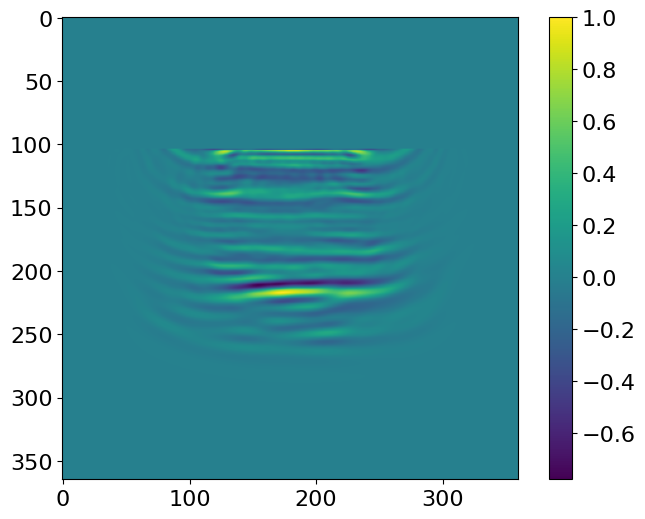

-0.7768386


In [18]:
import matplotlib.pyplot as plt
plt.imshow(update.data.T)
plt.colorbar()
plt.show()

print(update.data.min())

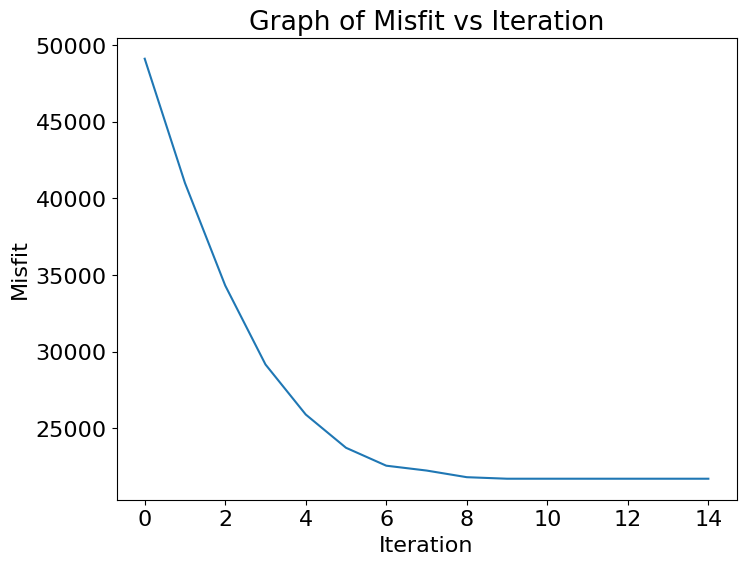

In [19]:
import matplotlib.pyplot as plt

plt.plot(misfiti)
plt.title("Graph of Misfit vs Iteration")
plt.xlabel("Iteration")
plt.ylabel('Misfit')
plt.show()

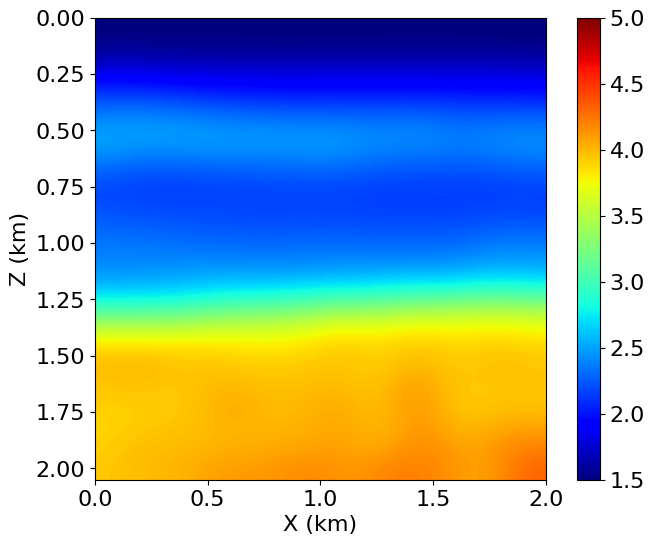

In [20]:
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(model0.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', vmin=1.5, vmax=5.0)
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

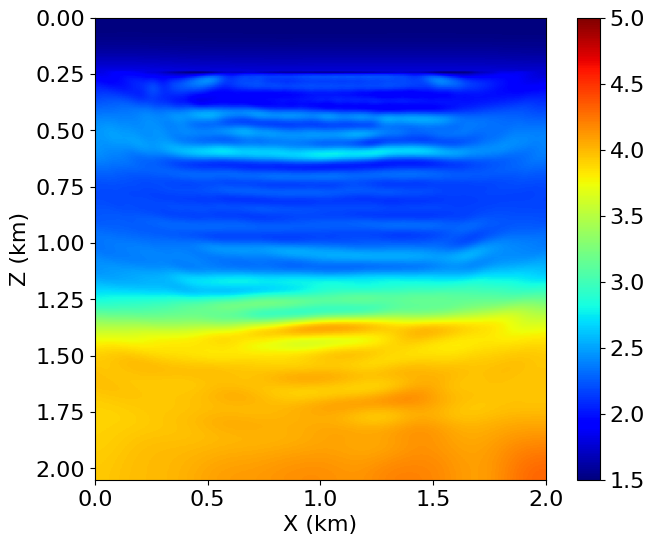

In [21]:
ibest = 0
min_misfit= 9999
for i in range(len(misfiti)):
    if misfiti[i]<min_misfit:
        min_misfit = misfiti[i]
        ibest = i
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(modeli[ibest].vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', vmin=1.5, vmax=5.0)
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

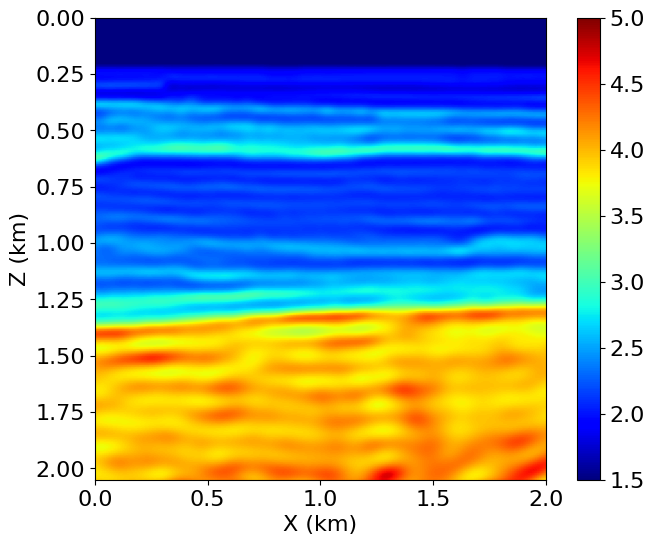

In [22]:
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(model.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet', vmin=1.5, vmax=5.0)
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

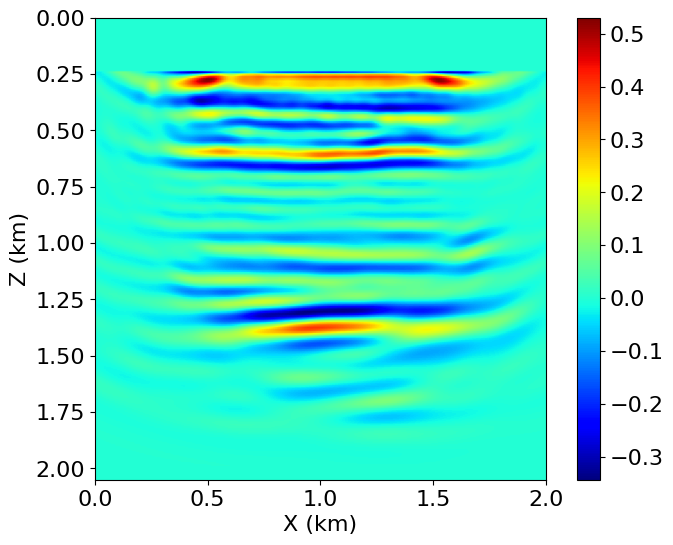

In [23]:
selisih_model = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)
selisih_model.vp.data[:] = modeli[ibest].vp.data[:] - model0.vp.data[:]
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(selisih_model.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

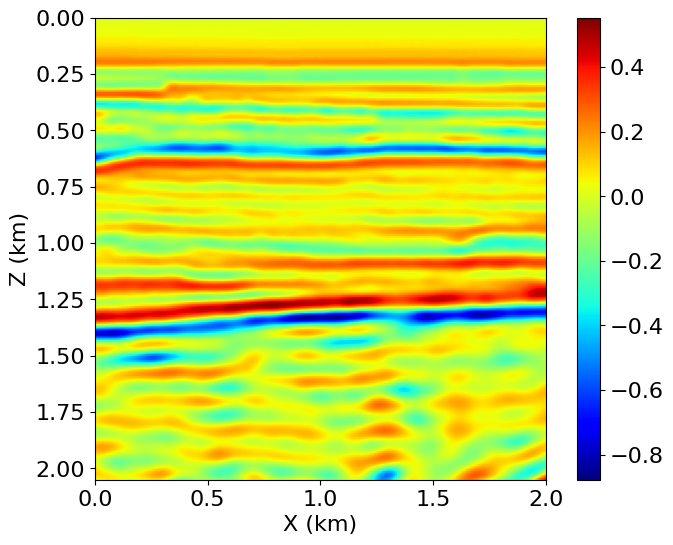

In [24]:
selisih_model1 = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)
selisih_model1.vp.data[:] =  model0.vp.data[:]-model.vp.data[:]
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(selisih_model1.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

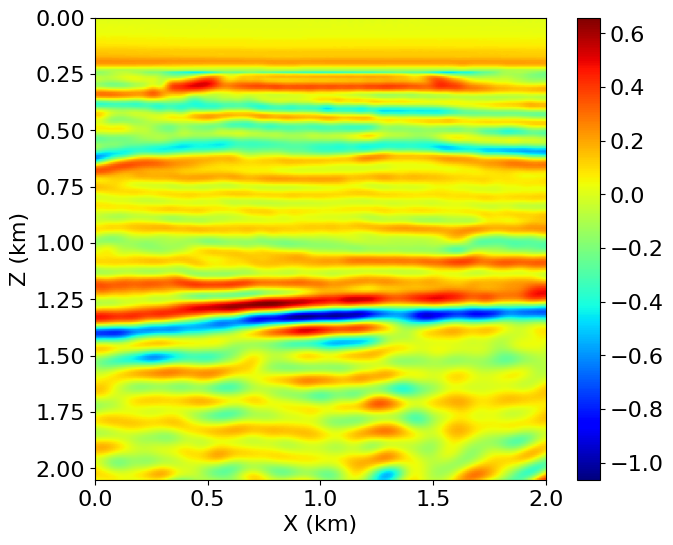

In [25]:
selisih_model2 = Model(vp=vp0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nboundary, bcs="damp", grid = model.grid)
selisih_model2.vp.data[:] = modeli[ibest].vp.data[:] - model.vp.data[:]
xmin = (origin[0]*spacing[0])/1000
zmin = (origin[1]*spacing[1])/1000
xmax = (origin[0]*spacing[0] + shape[0]*spacing[0])/1000
zmax = (origin[1]*spacing[1] + shape[1]*spacing[1])/1000
plt.imshow(selisih_model2.vp.data[nboundary:nboundary+shape[0], nboundary:nboundary+shape[1]].T, extent=[xmin, xmax, zmax, zmin], cmap='jet')
plt.colorbar()
plt.xlabel("X (km)")
plt.ylabel("Z (km)")
plt.show()

In [26]:
import numpy as np

# Contoh data model kecepatan (2D array)
velocity_model = np.array([[4.5, 5.7, 6.0],
                           [5.2, 5.6, 5.8],
                           [6.1, 5.5, 5.9]])

# Threshold kecepatan
threshold = 5.672030575879816

# Mengatur nilai yang lebih besar dari threshold menjadi nilai threshold
velocity_model[velocity_model > threshold] = threshold

# Menampilkan hasil
print(velocity_model)


[[4.5        5.67203058 5.67203058]
 [5.2        5.6        5.67203058]
 [5.67203058 5.5        5.67203058]]
